In [5]:
from cryptory import Cryptory

In [6]:
my_cryptory = Cryptory(from_date="2014-01-01")

In [7]:
my_cryptory

In [8]:
# Daily data from coinmarketcap
my_cryptory.extract_coinmarketcap("bitcoin")

,date,open,high,low,close,volume,marketcap
0,2018-09-08,6460.17,6534.25,6197.52,6225.98,3835060000,111471362532
1,2018-09-07,6528.92,6555.29,6396.87,6467.07,4264680000,112645200318
2,2018-09-06,6755.14,6755.14,6404.72,6529.17,5523470000,116535447253
3,2018-09-05,7361.46,7388.43,6792.83,6792.83,5800460000,126983440721
4,2018-09-04,7263.00,7388.26,7255.44,7361.66,4273640000,125273528713
5,2018-09-03,7279.03,7317.94,7208.15,7260.06,4087760000,125536575445
6,2018-09-02,7189.58,7306.31,7132.16,7272.72,4329540000,123981305470
7,2018-09-01,7044.81,7242.29,7038.05,7193.25,4116050000,121471295533
8,2018-08-31,6973.97,7057.17,6920.16,7037.58,4495650000,120236411575
9,2018-08-30,7043.76,7072.69,6834.69,6978.23,4463250000,121426092460


In [9]:
# Daily subscriber numbers to the bitcoin reddit page
my_cryptory.extract_reddit_metrics(subreddit="bitcoin", metric="total-subscribers")

,date,total_subscribers
0,2018-03-04,759794
1,2018-03-03,758588
2,2018-03-02,757549
3,2018-03-01,756510
4,2018-02-28,755471
5,2018-02-27,754432
6,2018-02-26,753393
7,2018-02-25,752354
8,2018-02-24,751315
9,2018-02-23,750276


In [14]:
# Google Trends - bitcoin search results
my_cryptory.get_google_trends(kw_list=["bitcoin"])

,date,bitcoin
0,2018-09-06,8.084752
1,2018-09-05,7.507269
2,2018-09-04,6.352305
3,2018-09-03,5.774823
4,2018-09-02,5.774823
5,2018-09-01,5.197340
6,2018-08-31,5.774823
7,2018-08-30,5.774823
8,2018-08-29,6.352305
9,2018-08-28,6.929787


In [11]:
# dow jones price (market code from yahoo finance)
my_cryptory.get_stock_prices(market="%5EDJI")

,date,adjclose,close,high,low,open,volume
0,2018-09-09,25916.539062,25916.539062,26002.990234,25818.390625,25951.019531,281350000.0
1,2018-09-08,25916.539062,25916.539062,26002.990234,25818.390625,25951.019531,281350000.0
2,2018-09-07,25916.539062,25916.539062,26002.990234,25818.390625,25951.019531,281350000.0
3,2018-09-06,25995.869141,25995.869141,26073.679688,25880.839844,25973.019531,262380000.0
4,2018-09-05,25974.990234,25974.990234,26011.220703,25871.039062,25919.839844,289210000.0
5,2018-09-04,25952.480469,25952.480469,25971.769531,25805.949219,25916.070312,254600000.0
6,2018-09-03,25964.820312,25964.820312,26028.830078,25879.769531,25964.849609,273440000.0
7,2018-09-02,25964.820312,25964.820312,26028.830078,25879.769531,25964.849609,273440000.0
8,2018-09-01,25964.820312,25964.820312,26028.830078,25879.769531,25964.849609,273440000.0
9,2018-08-31,25964.820312,25964.820312,26028.830078,25879.769531,25964.849609,273440000.0


In [12]:
# USD/EUR exchange rate
my_cryptory.get_exchange_rates(from_currency="USD", to_currency="EUR")

,date,exch_rate
0,2018-09-09,1.1615
1,2018-09-08,1.1615
2,2018-09-07,1.1615
3,2018-09-06,1.1634
4,2018-09-05,1.1582
5,2018-09-04,1.1562
6,2018-09-03,1.1651
7,2018-09-02,1.1651
8,2018-09-01,1.1651
9,2018-08-31,1.1651


In [13]:
# USD/EUR exchange rate
my_cryptory.get_exchange_rates(from_currency="USD", to_currency="EUR")

,date,exch_rate
0,2018-09-09,1.1615
1,2018-09-08,1.1615
2,2018-09-07,1.1615
3,2018-09-06,1.1634
4,2018-09-05,1.1582
5,2018-09-04,1.1562
6,2018-09-03,1.1651
7,2018-09-02,1.1651
8,2018-09-01,1.1651
9,2018-08-31,1.1651


In [15]:
# get historical commodity prices
my_cryptory.get_metal_prices()

,date,gold_am,gold_pm,silver,platinum_am,platinum_pm,palladium_am,palladium_pm
0,2018-09-09,1200.75,1198.90,14.185,793.0,776.0,979.0,982.0
1,2018-09-08,1200.75,1198.90,14.185,793.0,776.0,979.0,982.0
2,2018-09-07,1200.75,1198.90,14.185,793.0,776.0,979.0,982.0
3,2018-09-06,1204.30,1205.15,14.265,790.0,790.0,983.0,978.0
4,2018-09-05,1194.70,1196.70,14.170,774.0,774.0,982.0,988.0
5,2018-09-04,1195.75,1190.85,14.250,778.0,772.0,966.0,967.0
6,2018-09-03,1201.70,1200.05,14.525,787.0,788.0,985.0,980.0
7,2018-09-02,1206.85,1202.45,14.655,798.0,798.0,977.0,979.0
8,2018-09-01,1206.85,1202.45,14.655,798.0,798.0,977.0,979.0
9,2018-08-31,1206.85,1202.45,14.655,798.0,798.0,977.0,979.0


<class 'pandas.core.frame.DataFrame'>


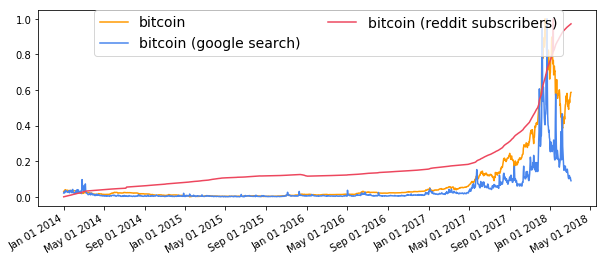

In [57]:
# generate price correlation matrix
import pandas as pd
import seaborn as sns
from cryptory import Cryptory
import datetime
import matplotlib.pyplot as plt

my_cryptory = Cryptory(from_date="2014-01-01")

df1 = my_cryptory.extract_coinmarketcap('bitcoin')[['date','close']]
df2 = my_cryptory.get_google_trends(kw_list=['bitcoin'])
df3 = my_cryptory.extract_reddit_metrics(subreddit="bitcoin", 
                                         metric="total-subscribers")

# btc_google = df1.merge(df2,on='date', how='inner')

btc_google = df1.merge(df2,on='date', how='inner').merge(df3,on='date', how='inner')
# print(btc_google)

# btc_google.to_csv('btc_data_reconciliation.csv')

# need to scale columns (min-max scaling)
btc_google[['bitcoin','close', 'total_subscribers']] = (
        btc_google[['bitcoin', 'close', 'total_subscribers']]-btc_google[['bitcoin', 'close', 'total_subscribers']].min())/(
        btc_google[['bitcoin', 'close', 'total_subscribers']].max()-btc_google[['bitcoin', 'close', 'total_subscribers']].min())

from sklearn.preprocessing import minmax_scale

# btc_google[['bitcoin','close', 'total_subscribers']] = minmax_scale(btc_google[['bitcoin','close', 'total_subscribers']])

print(type(btc_google[['bitcoin','close', 'total_subscribers']]))


# plt.plot(btc_google[['bitcoin','close', 'total_subscribers']])
%matplotlib inline
fig, ax1 = plt.subplots(1, 1, figsize=(10, 4)) # 1 row 1 col

fig.autofmt_xdate()

ax1.set_xticks([datetime.date(j,i,1) for i in range(1,13,4) for j in range(2014,2019)])
ax1.set_xticklabels([datetime.date(j,i,1).strftime('%b %d %Y') 
                     for i in range(1,13,4) for j in range(2014,2019)])
ax1.plot(btc_google['date'].astype(datetime.datetime),
             btc_google['close'], label='bitcoin', color='#FF9900')
ax1.plot(btc_google['date'].astype(datetime.datetime),
             btc_google['bitcoin'], label="bitcoin (google search)", color='#4885ed')
ax1.plot(btc_google['date'].astype(datetime.datetime),
             btc_google['total_subscribers'], label="bitcoin (reddit subscribers)", color='#ed475e')

ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., ncol=2, prop={'size': 14})
plt.show()

     btc_price  eth_price  xrp_price  bch_price  ltc_price  dash_price  \
0          NaN        NaN        NaN        NaN        NaN         NaN   
1    -0.002657   0.048401   0.031579   0.011367  -0.012030   -0.027929   
2     0.013009   0.050854  -0.003401   0.030821   0.022191   -0.051138   
3    -0.003249   0.014822  -0.023891  -0.004672  -0.017216   -0.052666   
4     0.109128   0.171384   0.069930   0.152073   0.148349    0.180662   
5     0.026172   0.085506   0.107843   0.083279   0.055349    0.071658   
6    -0.008592   0.008364   0.000000  -0.000976  -0.036232   -0.026232   
7    -0.002751   0.015716   0.005900   0.008804   0.007967    0.011699   
8    -0.018623  -0.013809  -0.008798  -0.087543  -0.012564   -0.017605   
9    -0.016868  -0.032512  -0.029586  -0.070707  -0.061183   -0.103069   
10   -0.006720   0.003459  -0.006098  -0.000416  -0.013159   -0.038361   
11    0.017274   0.036421   0.073620   0.035593   0.033478    0.061747   
12   -0.009905  -0.013516  -0.002857  

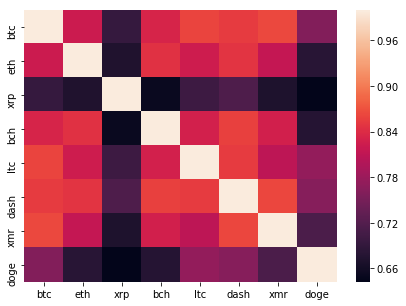

In [81]:
# Pearson correlation on all data sources
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

my_cryptory = Cryptory(from_date="2018-01-01")
all_coins_df = my_cryptory.extract_bitinfocharts("btc")
# coins of interest
bitinfocoins = ["btc", "eth", "xrp", "bch", "ltc", "dash", "xmr", "doge"]
for coin in bitinfocoins[1:]:
    all_coins_df = all_coins_df.merge(my_cryptory.extract_bitinfocharts(coin), on="date", how="left")
# date column not need for upcoming calculations
all_coins_df = all_coins_df.drop('date', axis=1)
# Percentage change => 
# first calculate: Increase = y_t - y_(t-1) then calculate: %Increace = (Increase-y_(t-1))*100
"""
    %Increase is used both to track the prices of individual securities and 
    of large market indexes, as well as comparing the values of different currencies.  
    Balance sheets with comparative financial statements will generally include the 
    prices of specific assets at different points in time along with the percentage 
    changes over the accompanying periods of time.  
""""
# Compute pairwise correlation of columns, excluding NA/null values
corr = all_coins_df.pct_change().corr(method='pearson')
fig, ax = plt.subplots(figsize=(7,5))  
sns.heatmap(corr, 
            xticklabels=[col.replace("_price", "") for col in corr.columns.values],
            yticklabels=[col.replace("_price", "") for col in corr.columns.values],
            annot_kws={"size": 16})
plt.show()

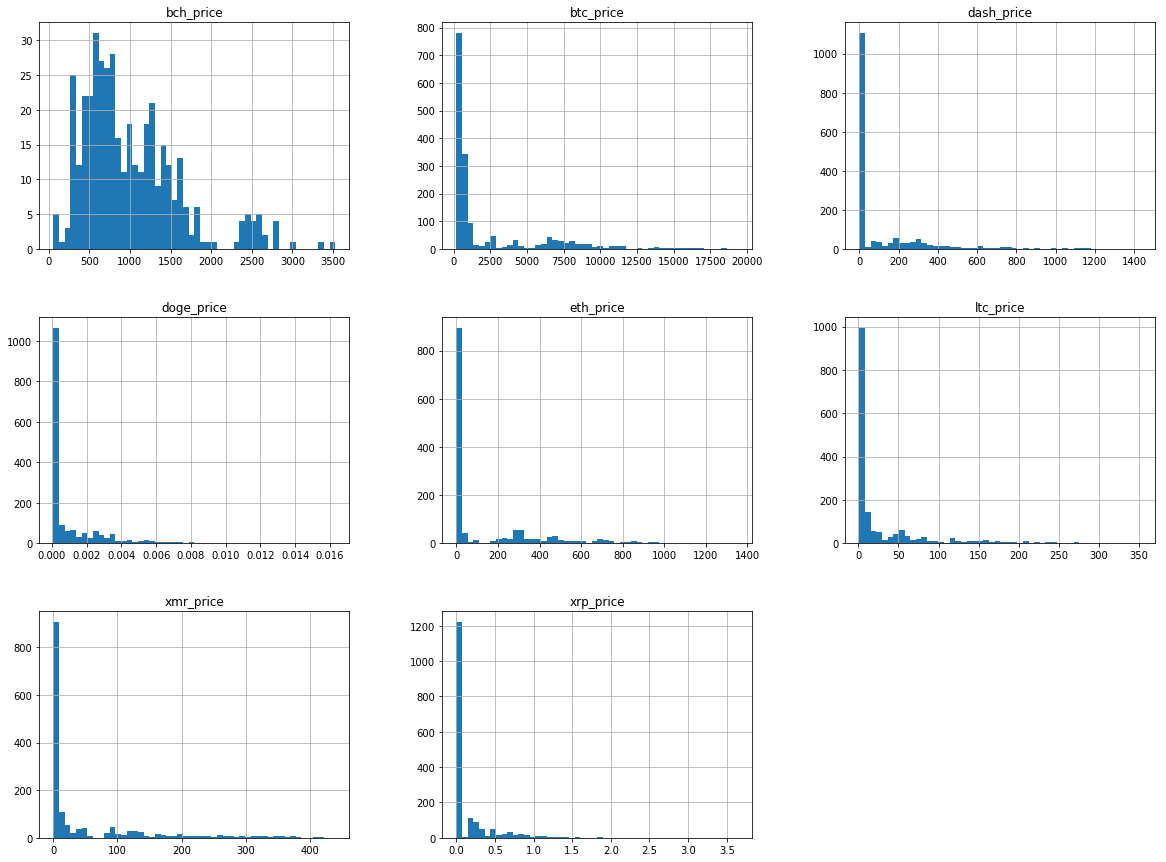

In [63]:
import matplotlib.pyplot as plt
all_coins_df.hist(bins=50, figsize=(20,15))
# print(all_coins_df)
plt.show()

In [64]:
df1 = my_cryptory.extract_coinmarketcap('bitcoin')[['date','close']]
df2 = my_cryptory.get_google_trends(kw_list=['bitcoin'])
df3 = my_cryptory.extract_reddit_metrics(subreddit="bitcoin", 
                                         metric="total-subscribers")

In [79]:
a = pd.Series([1,2,4,10]).pct_change()
a

0    NaN
1    1.0
2    1.0
3    1.5
dtype: float64

In [78]:
a


0    NaN
1    1.0
2    1.0
3    1.5
dtype: float64

2.5